In [23]:
%matplotlib widget

import math
import csv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import antropy as ant
from mpl_toolkits.mplot3d import axes3d



In [24]:
begin, end = 1, 61 # (begin is inclusive, end is exclusive)
num_people = 10
count_samples = {
    "active": 8,
    "meditate": 8,
    "neutral": 8
}

class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

    '''
    Scales the data by standard deviation of the EEG data
    '''
    def scale(self):
        eeg_std_dev = np.std(self.data['RawEEG'])
        self.data['Alpha'] = [x / eeg_std_dev for x in self.data['Alpha']]
        self.data['Delta'] = [x / eeg_std_dev for x in self.data['Delta']]
        self.data['Theta'] = [x / eeg_std_dev for x in self.data['Theta']]
        self.data['Low Beta'] = [x / eeg_std_dev for x in self.data['Low Beta']]
        self.data['High Beta'] = [x / eeg_std_dev for x in self.data['High Beta']]
        self.data['Gamma'] = [x / eeg_std_dev for x in self.data['Gamma']]

In [25]:
data = []
dataLabels = []

def transcribeFileToSample(personN: int, sampleN: int, state: str):
    sample_data = Sample()

    with open("data/all_data/" + state + "_" + str(personN) + "_" + str(sampleN) + ".csv") as f:
        reader = csv.reader(f)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)

        for key in sample_data.data:
            sample_data.data[key] = sample_data.data[key][begin:end]

        # sample_data.scale()

        data.append(sample_data)
        dataLabels.append(state)

for person in range(num_people):
    for state in count_samples:
        for i in range(count_samples[state]):
            transcribeFileToSample(person + 1, i + 1, state)

In [26]:
dataExtracted = []

def safety_check(x):
    if math.isnan(x): return 0
    if math.isinf(x): return 99999999999
    return x

for point in data:
    extractedPoint = []

    for key in point.data:
        for func in [np.mean, np.std, ant.sample_entropy, ant.petrosian_fd]:
            extractedPoint.append(safety_check(func(point.get(key))))

    extractedPoint.append(safety_check(ant.spectral_entropy(point.getEEG(), sf=1)))
    # extractedPoint.append(np.mean(point.getAlpha()))
    # extractedPoint.append(np.std(point.getAlpha()))

    # extractedPoint.append(np.mean(point.getLowBeta()))
    # extractedPoint.append(np.std(point.getLowBeta()))

    # extractedPoint.append(np.mean(point.getHighBeta()))
    # extractedPoint.append(np.std(point.getHighBeta()))

    # extractedPoint.append(np.mean(point.getGamma()))
    # extractedPoint.append(np.std(point.getGamma()))

    # extractedPoint.append(np.mean(point.getTheta()))
    # extractedPoint.append(np.std(point.getTheta()))

    # extractedPoint.append(np.mean(point.getDelta()))
    # extractedPoint.append(np.std(point.getDelta()))
    
    dataExtracted.append(extractedPoint)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: divide by zero encountered in log2
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: invalid value encountered in multiply
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)


In [27]:
def forest_test(X, y):
    X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, 
                                                        test_size = 0.25)
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,y_Train)
    predictionforest = trainedforest.predict(X_Test)
    print(classification_report(y_Test,predictionforest))

In [28]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(dataExtracted)

forest_test(X_pca, dataLabels)
# forest_test(dataExtracted, dataLabels)

              precision    recall  f1-score   support

      active       0.00      0.00      0.00        23
    meditate       0.36      0.50      0.42        16
     neutral       0.32      0.57      0.41        21

    accuracy                           0.33        60
   macro avg       0.23      0.36      0.28        60
weighted avg       0.21      0.33      0.25        60



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [32]:
pca.explained_variance_ratio_

array([0.84812344, 0.07972887, 0.07214769])

In [29]:
principalDf = pd.DataFrame(data = X_pca, columns = ['PCA1', 'PCA2', 'PCA3'])
labelsDf = pd.DataFrame(data = dataLabels, columns = ['target'])

df = pd.concat((principalDf, labelsDf), axis = 1)

In [39]:
df

,PCA1,PCA2,PCA3,target
0,-4.600018e+09,-4.385706e+08,4.073540e+07,active
1,-4.600018e+09,-4.385706e+08,4.073540e+07,active
2,-4.600018e+09,-4.385706e+08,4.073540e+07,active
3,-4.600018e+09,-4.385706e+08,4.073540e+07,active
4,-4.600018e+09,-4.385706e+08,4.073540e+07,active
...,...,...,...,...
235,-4.600018e+09,-4.385706e+08,4.073540e+07,neutral
236,-4.600018e+09,-4.385706e+08,4.073540e+07,neutral
237,-4.600018e+09,-4.385706e+08,4.073540e+07,neutral
238,-4.600018e+09,-4.385706e+08,4.073540e+07,neutral


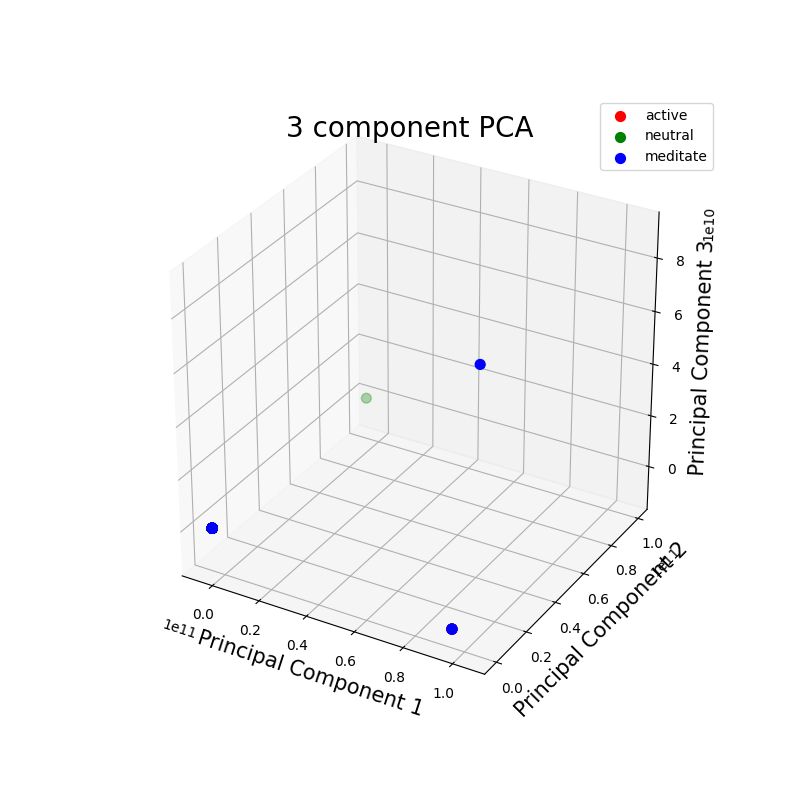

In [38]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = ['active', 'neutral', 'meditate']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(df.loc[indicesToKeep, 'PCA1']
               , df.loc[indicesToKeep, 'PCA2']
               , df.loc[indicesToKeep, 'PCA3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [31]:
# combine regular features + PCA data extracted features for ultimate X
test = np.concatenate((dataExtracted, X_pca), axis=1)